# IMPORT LIBRERIE E CSV

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [313]:
df = pd.read_csv(
    "Cars_Datasets_2025.csv",
    sep=",",
    engine="python",
    quotechar='"',
    encoding="cp1252", # Windows encoding
    on_bad_lines="warn"
)
df.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm


# INFO DATASET

In [314]:
print("--- INFO prima conversione ---")
df.info()

--- INFO prima conversione ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Names              1218 non-null   object
 1   Cars Names                 1218 non-null   object
 2   Engines                    1218 non-null   object
 3   CC/Battery Capacity        1215 non-null   object
 4   HorsePower                 1218 non-null   object
 5   Total Speed                1218 non-null   object
 6   Performance(0 - 100 )KM/H  1212 non-null   object
 7   Cars Prices                1218 non-null   object
 8   Fuel Types                 1218 non-null   object
 9   Seats                      1218 non-null   object
 10  Torque                     1217 non-null   object
dtypes: object(11)
memory usage: 104.8+ KB


Abbiamo 11 colonne con oggetti -> dtypes: object(11)
- .info() mostra object perché le colonne contengono testo/simboli
- Per convertire uso funzioni di pulizia che rimuovono unità, simboli e gestiscono nan
- Colonna: 3,6,10 hanno oggetti nulli -> pochi in proporzione -> li elimino

# PULIZIA DEL DATASET

In [315]:
for col in ["Company Names","Cars Names","Engines","CC/Battery Capacity","HorsePower","Total Speed","Performance(0 - 100 )KM/H","Cars Prices","Fuel Types","Seats","Torque"]:
    group_df = df.groupby(col).count()
    print(df[col].nunique())
    print(group_df)

37
                   Cars Names  Engines  CC/Battery Capacity  HorsePower  \
Company Names                                                             
ASTON MARTIN               11       11                   11          11   
AUDI                       21       21                   21          21   
Acura                      27       27                   27          27   
BENTLEY                     1        1                    1           1   
BMW                        41       41                   41          41   
Bugatti                    10       10                   10          10   
Cadillac                   20       20                   20          20   
Chevrolet                  58       58                   58          58   
FERRARI                     9        9                    9           9   
Ford                       54       54                   54          54   
GMC                        59       59                   59          59   
HONDA                 

Andiamo a pulire tutti i dati

## Normalizzazione Company Names

In [316]:
# Tolgo i doppioni
df["Company Names"] = (
    df["Company Names"]
    .astype(str)
    .str.strip()
    .str.upper()
    .str.replace(r"\s+", " ", regex=True)
)

## Eliminazione colonna 'Engines' -> mostro i 5 più rilevanti

In [317]:
# Conteggio motori
engine_counts = df['Engines'].value_counts()
print("Conteggio motori:\n", engine_counts)

# Percentuale di ogni motore sul totale
engine_percentage = df['Engines'].value_counts(normalize=True) * 100
print("\nPercentuale motori sul totale:\n", engine_percentage.round(2))

# Elimino la colonna Engines dal DataFrame
df = df.drop(columns=['Engines'])
print("\nColonna 'Engines' eliminata" )

Conteggio motori:
 Engines
I4                              64
V12                             51
V6                              39
Inline-4                        38
V8                              34
                                ..
1.4L I4 Diesel / 1.6L Diesel     1
2.0L I4 Turbo Diesel             1
2.7L Turbo engine                1
1.5L I4 Turbo                    1
2.5L Hybrid / Plug-in Hybrid     1
Name: count, Length: 356, dtype: int64

Percentuale motori sul totale:
 Engines
I4                              5.25
V12                             4.19
V6                              3.20
Inline-4                        3.12
V8                              2.79
                                ... 
1.4L I4 Diesel / 1.6L Diesel    0.08
2.0L I4 Turbo Diesel            0.08
2.7L Turbo engine               0.08
1.5L I4 Turbo                   0.08
2.5L Hybrid / Plug-in Hybrid    0.08
Name: proportion, Length: 356, dtype: float64

Colonna 'Engines' eliminata


I 5 motori più frequenti sono:
1. I4 (64) -> 5.25%
2. V12 (51) -> 4.19%
3. V6 (39) -> 3.20%
4. Inline-4 (38) -> 3.12%
5. V8 (34) -> 2.79%

## Da stringhe a numeri: pulizia unità e simboli

In [318]:
def extract_numeric(s):
    if pd.isna(s):
        return np.nan
    
    s = str(s)
    s = s.replace('–','-')  # Sostituisci trattino lungo con normale
    s = s.replace(',', '')
    
    # Valori come "2+2" (in Seats) li interpreto come somma
    if re.fullmatch(r'\d+\s*\+\s*\d+', s):
        a, b = re.split(r'\s*\+\s*', s)
        return float(a) + float(b)
    
    # Estrai tutti i numeri (anche decimali)
    numbers = re.findall(r'\d+(?:\.\d+)?', s)
    if len(numbers) == 0:
        return np.nan
    
    # Converti in float e calcola la media se più di uno (intervalli)
    numbers = [float(n) for n in numbers]
    return np.mean(numbers)

# Applica alle colonne principali
numeric_cols_map = {
    'HorsePower_numeric': 'HorsePower',
    'Total_Speed_numeric': 'Total Speed',
    'Torque_numeric': 'Torque',
    'CC_Battery_numeric': 'CC/Battery Capacity',
    'Performance_numeric': 'Performance(0 - 100 )KM/H',
    'Cars_Prices_numeric': 'Cars Prices',
    'Seats_numeric': 'Seats'
}

for new_col, old_col in numeric_cols_map.items():
    df[new_col] = df[old_col].apply(extract_numeric)

print(df[[*numeric_cols_map.keys()]].head())

   HorsePower_numeric  Total_Speed_numeric  Torque_numeric  \
0               963.0                340.0           800.0   
1               563.0                250.0           900.0   
2                77.5                165.0           120.0   
3               630.0                250.0           900.0   
4               602.0                320.0           560.0   

   CC_Battery_numeric  Performance_numeric  Cars_Prices_numeric  Seats_numeric  
0              3990.0                  2.5            1100000.0            2.0  
1              6749.0                  5.3             460000.0            5.0  
2              1200.0                 10.5              13500.0            5.0  
3              3982.0                  3.2             161000.0            4.0  
4              5204.0                  3.6             253290.0            2.0  


Ora ho tutto numerico -> con la media per gli intervalli

### Descizione

In [319]:
numeric_cols = ['HorsePower_numeric','Total_Speed_numeric','Cars_Prices_numeric','Torque_numeric','CC_Battery_numeric','Performance_numeric','Seats_numeric']
df[numeric_cols].describe()

,HorsePower_numeric,Total_Speed_numeric,Cars_Prices_numeric,Torque_numeric,CC_Battery_numeric,Performance_numeric,Seats_numeric
count,1218.000000,1218.000000,1.217000e+03,1217.000000,1213.000000,1212.000000,1218.000000
mean,307.422824,216.467159,1.380370e+05,506.892358,2703.311689,7.564686,4.859606
std,222.722922,53.051077,7.110424e+05,1049.512321,1942.861991,3.312010,1.504306
min,26.000000,80.000000,4.000000e+03,45.000000,1.240000,1.900000,1.000000
25%,153.250000,180.000000,2.800000e+04,250.000000,1500.000000,5.275000,4.000000
50%,255.000000,200.000000,4.250000e+04,370.000000,2000.000000,7.100000,5.000000
75%,400.000000,250.000000,7.000000e+04,560.000000,3500.000000,9.500000,5.000000
max,2488.000000,500.000000,1.800000e+07,15590.000000,16100.000000,35.000000,20.000000


Per i posti a sedere ho: min = 1 posto (ok) | max = 20 posti (da gestire)

## Funzione per classificare Fuel Types

In [320]:
def normalize_fuel(x):
    if pd.isna(x):
        return np.nan

    t = str(x).lower().strip()

    # --- PLUG-IN HYBRID ---
    if re.search(r"plug[\s\-]*in", t) or "phev" in t or "hybrid / plug-in" in t:
        return "plug-in hybrid"

    # --- ELECTRIC ---
    if ("electric" in t or "ev" in t or "full electric" in t) and "hybrid" not in t:
        return "electric"

    # --- HYDROGEN ---
    if "hydrogen" in t or "fuel cell" in t:
        return "hydrogen"

    # --- HYBRID (non plug-in) ---
    if "hybrid" in t and "plug" not in t:
        return "hybrid"

    # --- PETROL ---
    if "petrol" in t or "gasoline" in t:
        return "petrol"

    # --- DIESEL ---
    if "diesel" in t:
        return "diesel"

    # --- CNG/LPG ---
    if "cng" in t or "lpg" in t or "gas" in t: # CNG: Compressed Natural Gas | LPG: Liquefied Petroleum Gas
        return "cng/lpg"

    # fallback
    return t

# Applico la normalizzazione
df["Fuel Types Clean"] = df["Fuel Types"].apply(normalize_fuel)

# Controllo i valori unici (per vedere se ci sono errori di battitura)
for col in ['Company Names', 'Fuel Types Clean']:
    print(col, df[col].unique())

Company Names ['FERRARI' 'ROLLS ROYCE' 'FORD' 'MERCEDES' 'AUDI' 'BMW' 'ASTON MARTIN'
 'BENTLEY' 'LAMBORGHINI' 'TOYOTA' 'NISSAN' 'VOLVO' 'KIA' 'HONDA' 'HYUNDAI'
 'MAHINDRA' 'MARUTI SUZUKI' 'VOLKSWAGEN' 'PORSCHE' 'CADILLAC'
 'TATA MOTORS' 'TESLA' 'JEEP' 'MAZDA' 'CHEVROLET' 'GMC' 'PEUGEOT'
 'BUGATTI' 'JAGUAR LAND ROVER' 'ACURA' 'MITSUBISHI']
Fuel Types Clean ['plug-in hybrid' 'petrol' 'diesel' 'hybrid' 'electric' 'hydrogen']


## OUTLIER

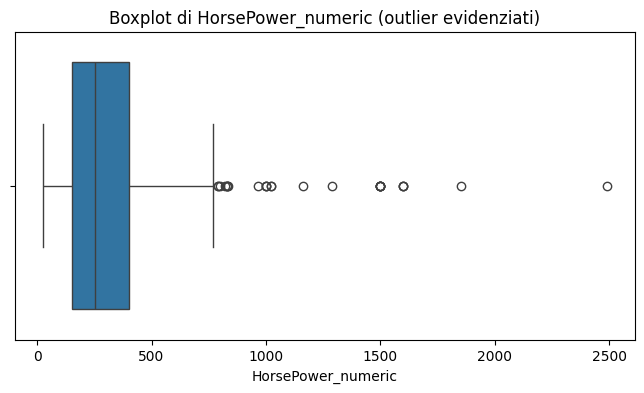


Colonna: HorsePower_numeric
Numero di outlier: 27
     HorsePower_numeric
0                 963.0
10                789.0
13                789.0
32               1160.0
33               1000.0
41                836.0
42                819.0
255              2488.0
660              1020.0
664              1020.0
667               800.0
668              1288.0
795               830.0
796              1000.0
810               830.0
812              1000.0
819               830.0
880              1500.0
881              1500.0
882              1600.0
883              1500.0
884              1500.0
885              1500.0
886              1600.0
887              1500.0
888              1850.0
889              1600.0


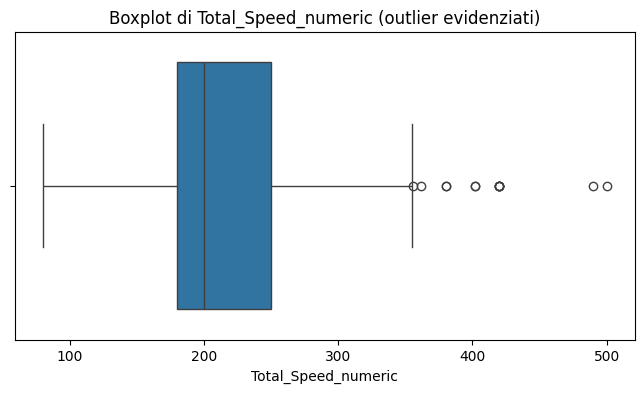


Colonna: Total_Speed_numeric
Numero di outlier: 13
     Total_Speed_numeric
8                  356.0
32                 402.0
33                 362.0
668                402.0
880                420.0
882                490.0
883                420.0
884                420.0
885                380.0
886                380.0
887                420.0
888                500.0
889                420.0


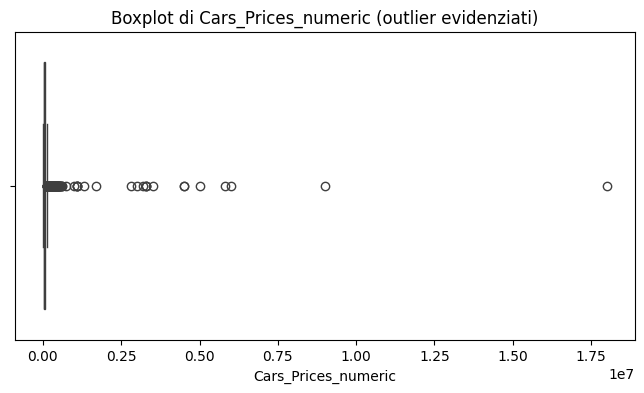


Colonna: Cars_Prices_numeric
Numero di outlier: 148
      Cars_Prices_numeric
0               1100000.0
1                460000.0
3                161000.0
4                253290.0
5                499000.0
...                   ...
953              150000.0
958              157000.0
961              157000.0
1036             500000.0
1212            6000000.0

[148 rows x 1 columns]


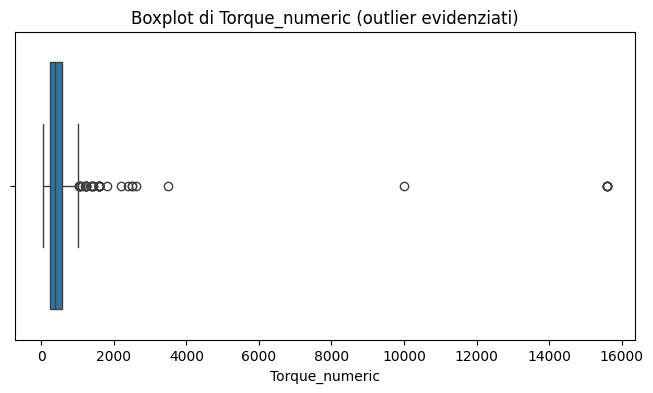


Colonna: Torque_numeric
Numero di outlier: 39
      Torque_numeric
561           1050.0
607           1050.0
660           1400.0
664           1400.0
667           1355.0
668          10000.0
716           1234.0
739           1234.0
749           1234.0
768           1234.0
776           1234.0
795          15590.0
796          15590.0
810          15590.0
811           1064.0
812          15590.0
819          15590.0
880           1600.0
881           1600.0
882           1600.0
883           1600.0
884           1600.0
885           1600.0
886           1600.0
887           1600.0
888           1600.0
889           1600.0
890           2600.0
891           3500.0
892           2200.0
893           2500.0
894           2400.0
895           1800.0
896           2500.0
897           1200.0
1028          1125.0
1032          1051.0
1048          1424.0
1049          1424.0


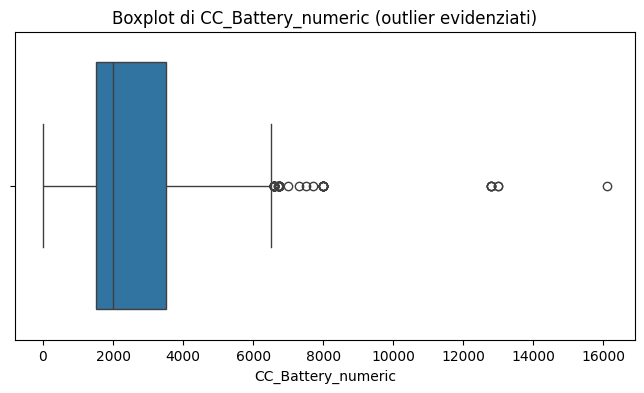


Colonna: CC_Battery_numeric
Numero di outlier: 67
      CC_Battery_numeric
1                 6749.0
65                6592.0
66                6592.0
67                6592.0
68                6749.0
...                  ...
1028              7000.0
1048              6700.0
1049              6700.0
1057              7300.0
1107              7500.0

[67 rows x 1 columns]


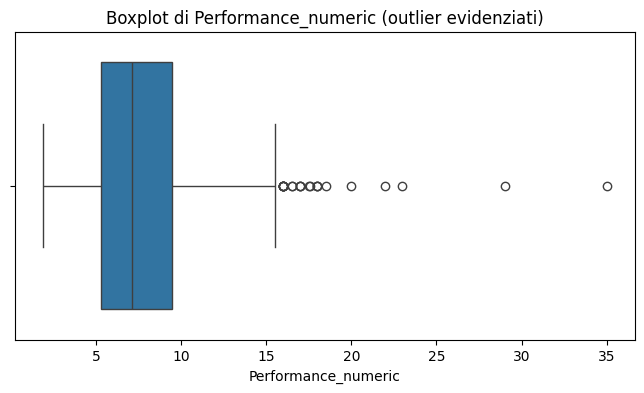


Colonna: Performance_numeric
Numero di outlier: 23
      Performance_numeric
317                  23.0
318                  17.5
477                  18.0
478                  18.5
635                  29.0
636                  16.0
637                  16.0
641                  16.5
643                  17.0
645                  17.0
652                  16.0
655                  17.6
892                  16.0
893                  16.5
895                  17.0
896                  18.0
897                  20.0
898                  22.0
1125                 16.0
1162                 16.0
1174                 18.0
1182                 16.0
1197                 35.0


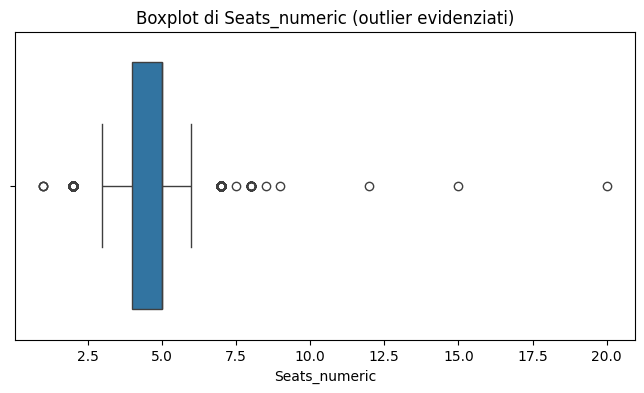


Colonna: Seats_numeric
Numero di outlier: 322
      Seats_numeric
0               2.0
4               2.0
5               2.0
6               2.0
8               2.0
...             ...
1206            2.0
1208            2.0
1209            2.0
1212            1.0
1214            7.0

[322 rows x 1 columns]


In [321]:
# Funzione per calcolare IQR e individuare outlier
def find_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

# Loop su tutte le colonne
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot di {col} (outlier evidenziati)')
    plt.show()

    outliers = find_outliers(df, col)
    print(f"\nColonna: {col}")
    print(f"Numero di outlier: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers[[col]])

### Company Names vs Cars_Prices_numeric

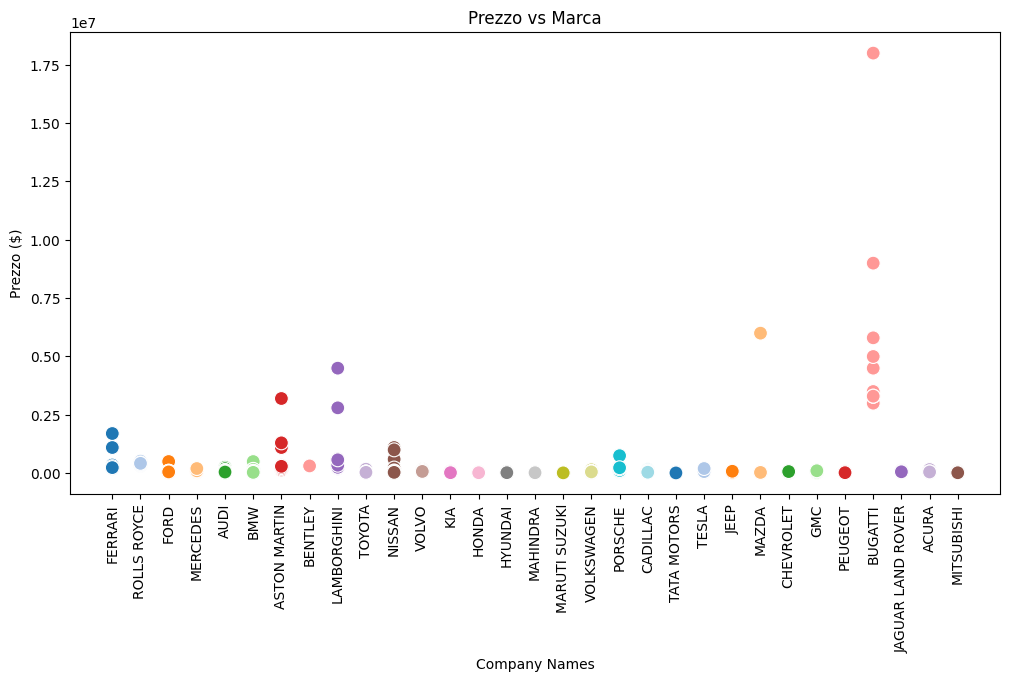

In [322]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='Company Names', 
    y='Cars_Prices_numeric', 
    data=df,
    hue='Company Names',   # colore diverso per ogni marca
    palette='tab20',       # palette colori
    s=100                  # dimensione punti
)
plt.xticks(rotation=90)    # ruota le etichette delle marche
plt.ylabel('Prezzo ($)')
plt.title('Prezzo vs Marca')
plt.legend([],[], frameon=False)  # nasconde la legenda per non sovraccaricare
plt.show()

### Performance_numeric VS Cars_Prices_numeric

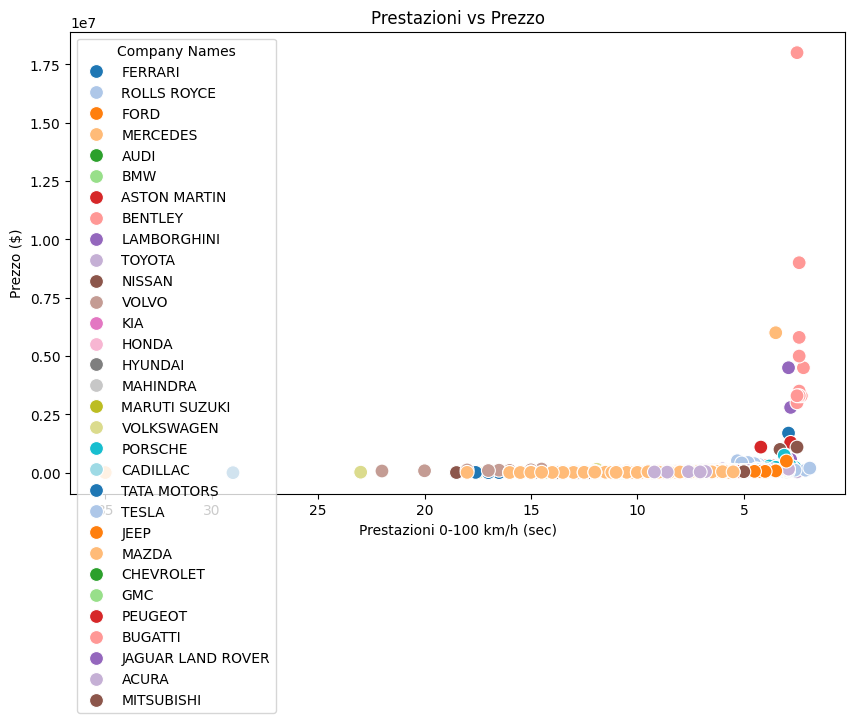

In [323]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='Performance_numeric', 
    y='Cars_Prices_numeric', 
    data=df,
    hue='Company Names',   # colore per la marca
    palette='tab20',
    s=100
)

plt.gca().invert_xaxis()

plt.xlabel('Prestazioni 0-100 km/h (sec)')
plt.ylabel('Prezzo ($)')
plt.title('Prestazioni vs Prezzo')
plt.show()

### Matrice di correlazione

                     HorsePower_numeric  Total_Speed_numeric  \
HorsePower_numeric             1.000000             0.703423   
Total_Speed_numeric            0.703423             1.000000   
Cars_Prices_numeric            0.507274             0.387830   
Torque_numeric                 0.400041             0.093918   
CC_Battery_numeric             0.548480             0.315675   
Performance_numeric           -0.640067            -0.785148   
Seats_numeric                 -0.235627            -0.394590   

                     Cars_Prices_numeric  Torque_numeric  CC_Battery_numeric  \
HorsePower_numeric              0.507274        0.400041            0.548480   
Total_Speed_numeric             0.387830        0.093918            0.315675   
Cars_Prices_numeric             1.000000        0.095808            0.274898   
Torque_numeric                  0.095808        1.000000            0.107256   
CC_Battery_numeric              0.274898        0.107256            1.000000   
Perform

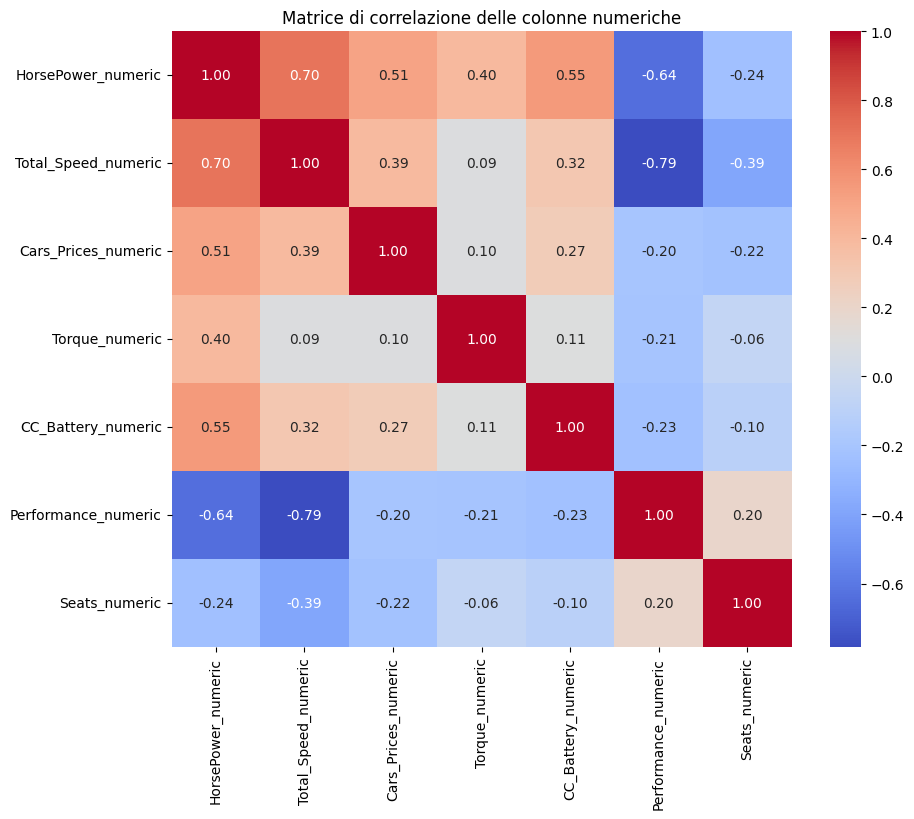

In [324]:
# Calcolo matrice di correlazione
corr_matrix = df[numeric_cols].corr()
print(corr_matrix)

# Heatmap per visualizzarla
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice di correlazione delle colonne numeriche")
plt.show()

### Scatter plot

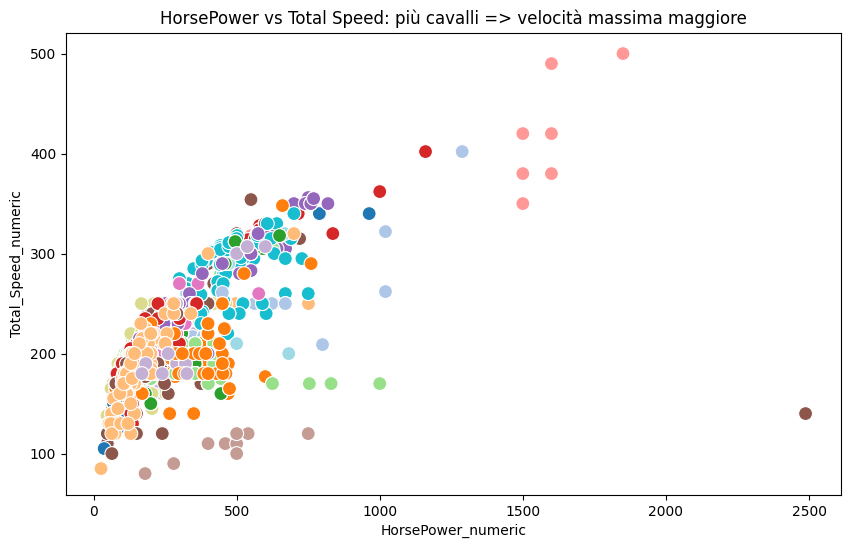

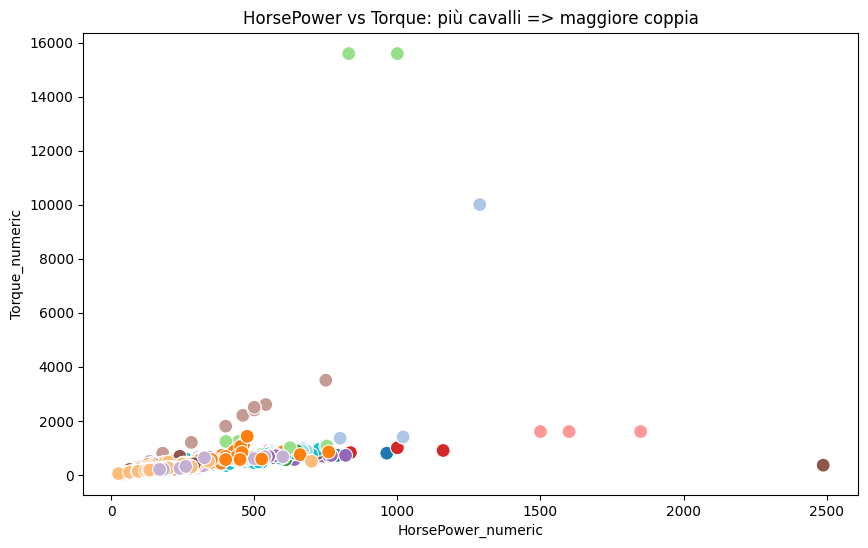

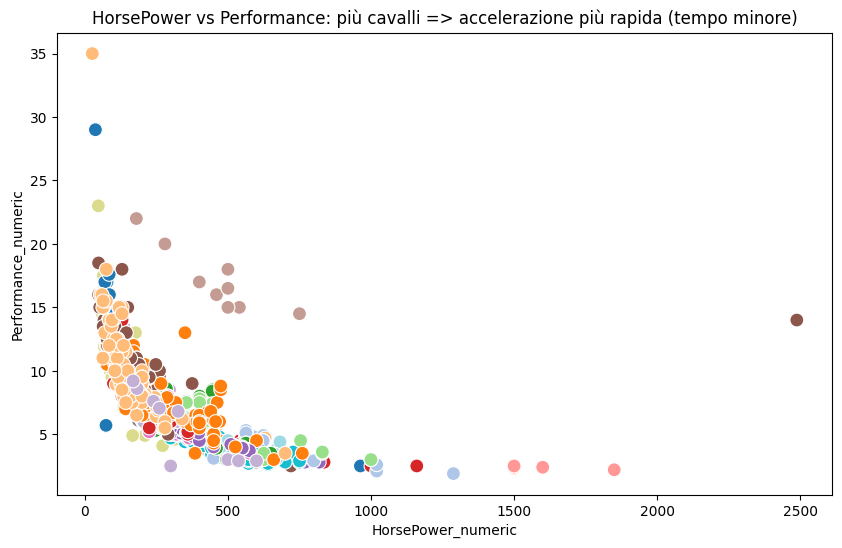

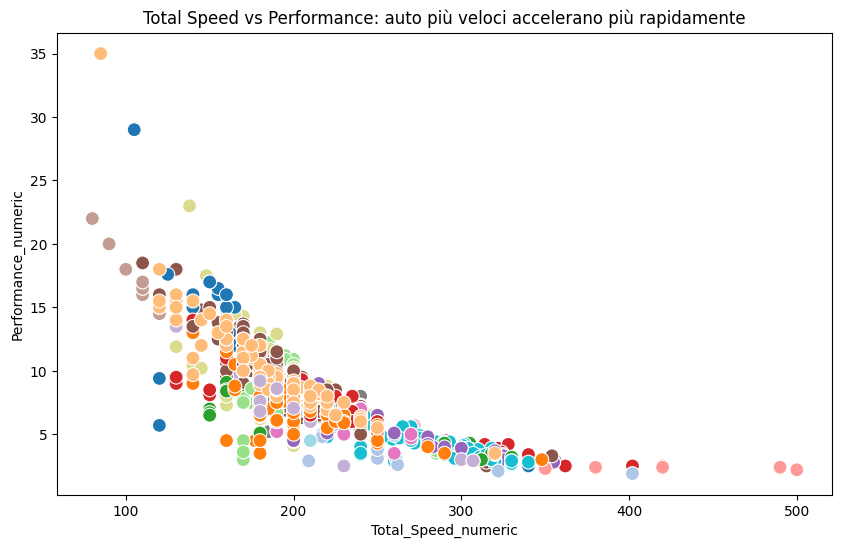

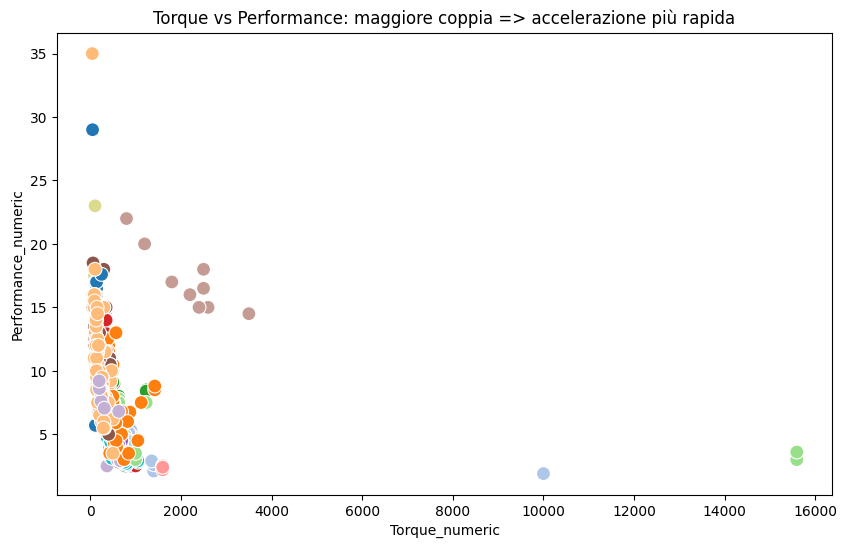

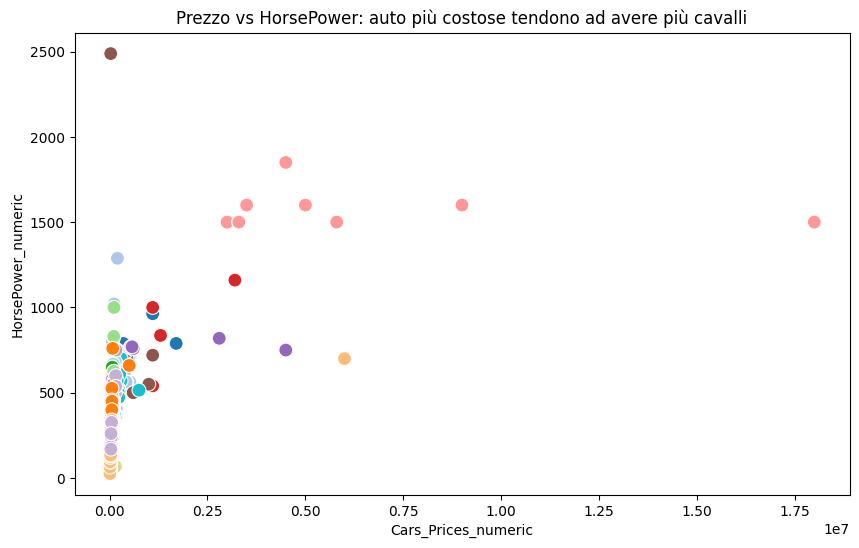

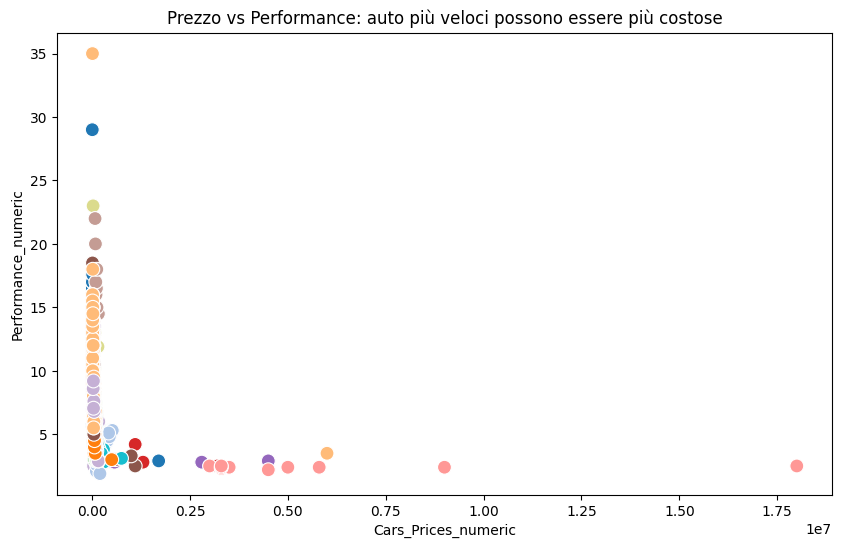

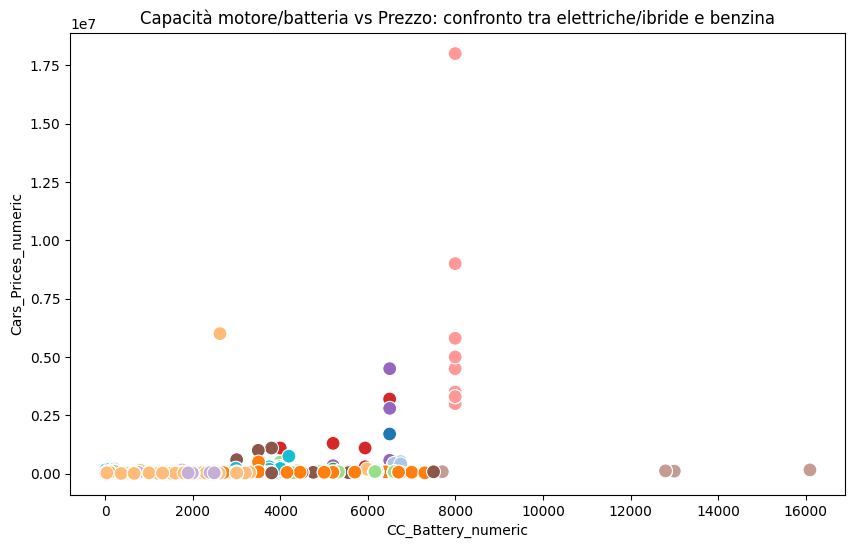

In [325]:
# Lista dei grafici scatter da creare
scatter_plots = [
    ('HorsePower_numeric', 'Total_Speed_numeric', 'HorsePower vs Total Speed: più cavalli => velocità massima maggiore'),
    ('HorsePower_numeric', 'Torque_numeric', 'HorsePower vs Torque: più cavalli => maggiore coppia'),
    ('HorsePower_numeric', 'Performance_numeric', 'HorsePower vs Performance: più cavalli => accelerazione più rapida (tempo minore)'),
    ('Total_Speed_numeric', 'Performance_numeric', 'Total Speed vs Performance: auto più veloci accelerano più rapidamente'),
    ('Torque_numeric', 'Performance_numeric', 'Torque vs Performance: maggiore coppia => accelerazione più rapida'),
    ('Cars_Prices_numeric', 'HorsePower_numeric', 'Prezzo vs HorsePower: auto più costose tendono ad avere più cavalli'),
    ('Cars_Prices_numeric', 'Performance_numeric', 'Prezzo vs Performance: auto più veloci possono essere più costose'),
    ('CC_Battery_numeric', 'Cars_Prices_numeric', 'Capacità motore/batteria vs Prezzo: confronto tra elettriche/ibride e benzina')
]

# Creazione dei grafici
for x_col, y_col, comment in scatter_plots:
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        x=x_col, 
        y=y_col, 
        data=df, 
        hue='Company Names', 
        palette='tab20', 
        s=100
    )
    plt.title(comment)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend([],[], frameon=False)  # nasconde legenda per chiarezza
    plt.show()

## RIMUOVO OUTLIER

In [326]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

# Creo una copia pulita
df_clean = df.copy()

# Colonne numeriche pulite
numeric_cols = ['HorsePower_numeric','Total_Speed_numeric','Cars_Prices_numeric', 'Torque_numeric','CC_Battery_numeric','Performance_numeric']

# Rimuovo gli outlier in tutte le colonne numeriche
for col in numeric_cols:
    df_clean = remove_outliers(df_clean, col)

print(f"Dati originali: {len(df)}, Dati senza outlier: {len(df_clean)}")

Dati originali: 1218, Dati senza outlier: 927


### Matrice di correlazione senza outlier

Matrice di correlazione senza outlier:

                     HorsePower_numeric  Total_Speed_numeric  \
HorsePower_numeric             1.000000             0.741655   
Total_Speed_numeric            0.741655             1.000000   
Cars_Prices_numeric            0.861378             0.702773   
Torque_numeric                 0.889865             0.611536   
CC_Battery_numeric             0.383115             0.374318   
Performance_numeric           -0.828076            -0.806650   

                     Cars_Prices_numeric  Torque_numeric  CC_Battery_numeric  \
HorsePower_numeric              0.861378        0.889865            0.383115   
Total_Speed_numeric             0.702773        0.611536            0.374318   
Cars_Prices_numeric             1.000000        0.813334            0.275925   
Torque_numeric                  0.813334        1.000000            0.323452   
CC_Battery_numeric              0.275925        0.323452            1.000000   
Performance_numeric            

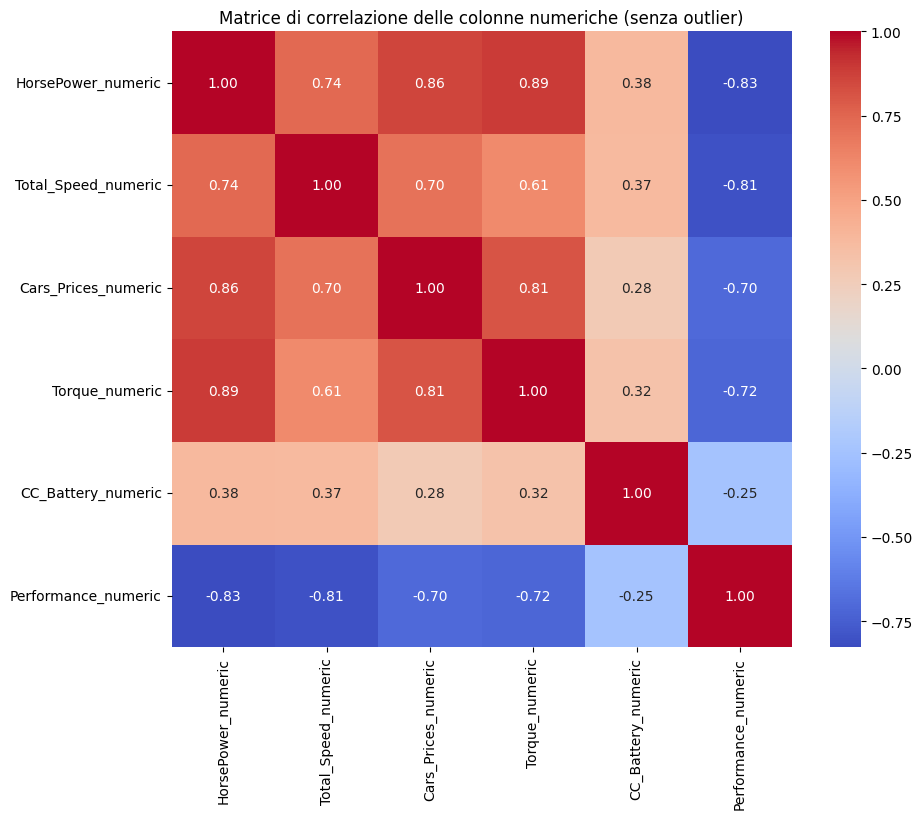

In [327]:

# Calcolo matrice di correlazione senza outlier
corr_clean = df_clean[numeric_cols].corr()

# Stampo la matrice senza outlier
print("Matrice di correlazione senza outlier:\n")
print(corr_clean)

# Heatmap per visualizzarla
plt.figure(figsize=(10,8))
sns.heatmap(corr_clean, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice di correlazione delle colonne numeriche (senza outlier)")
plt.show()

### Scatter Plot

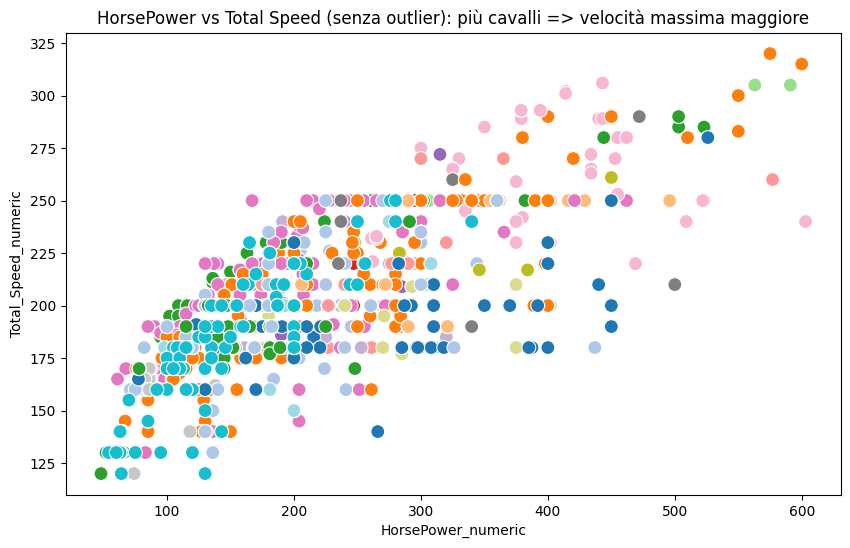

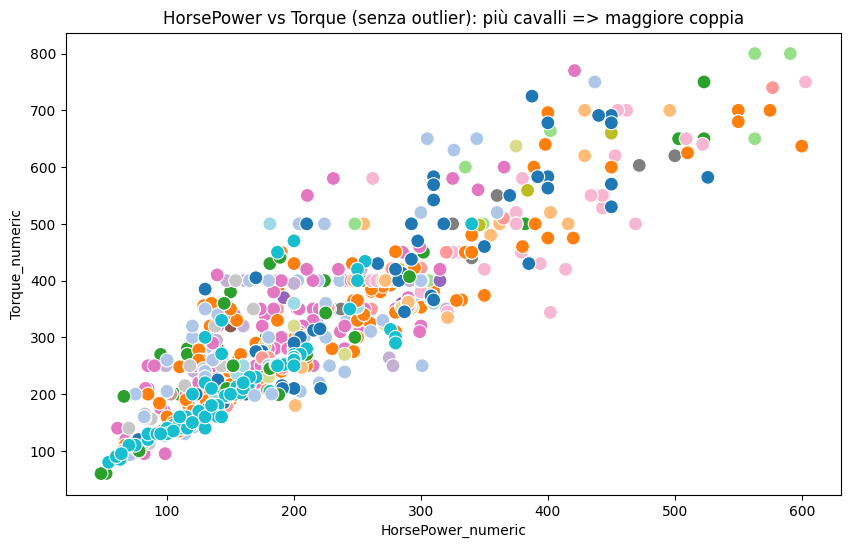

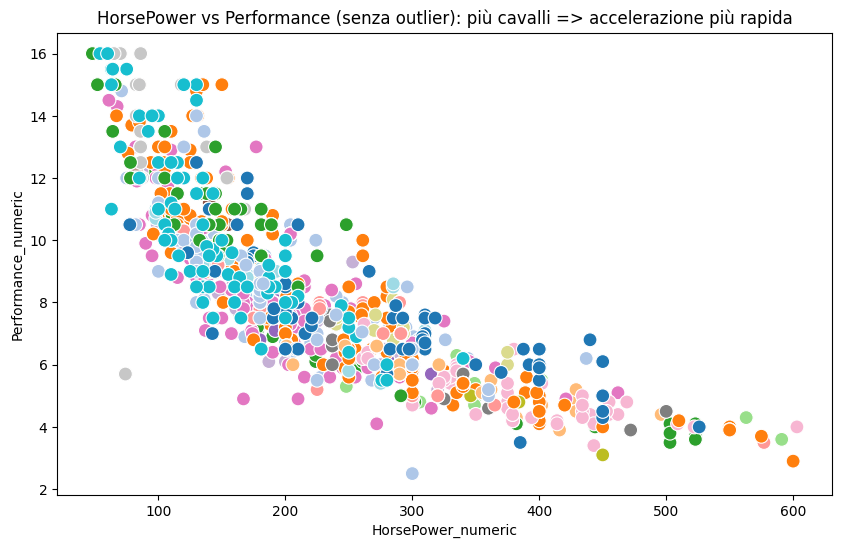

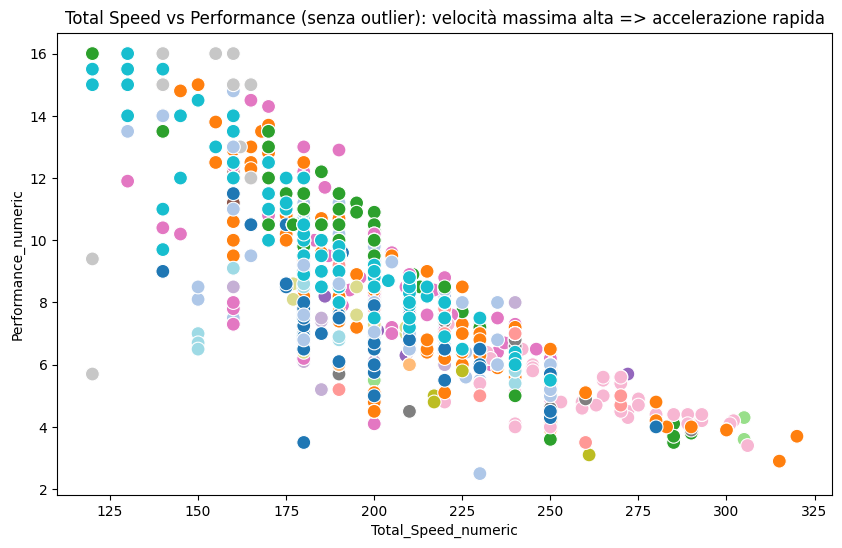

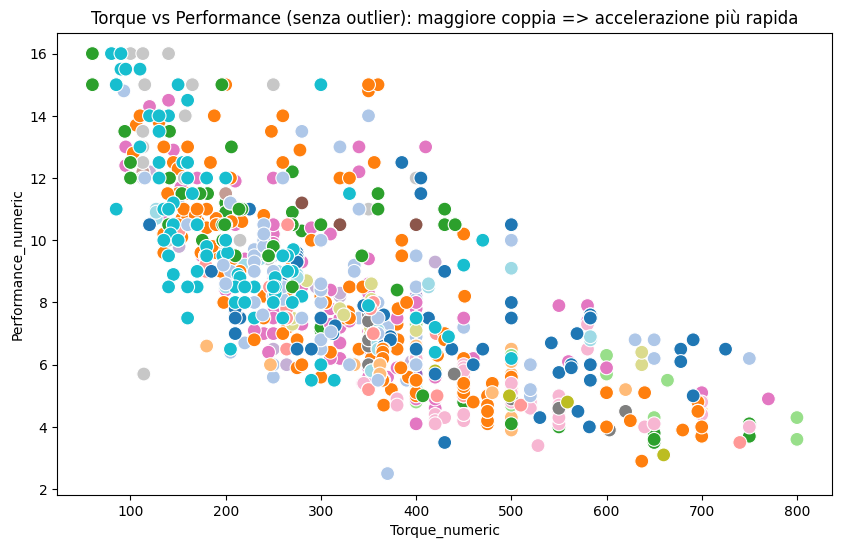

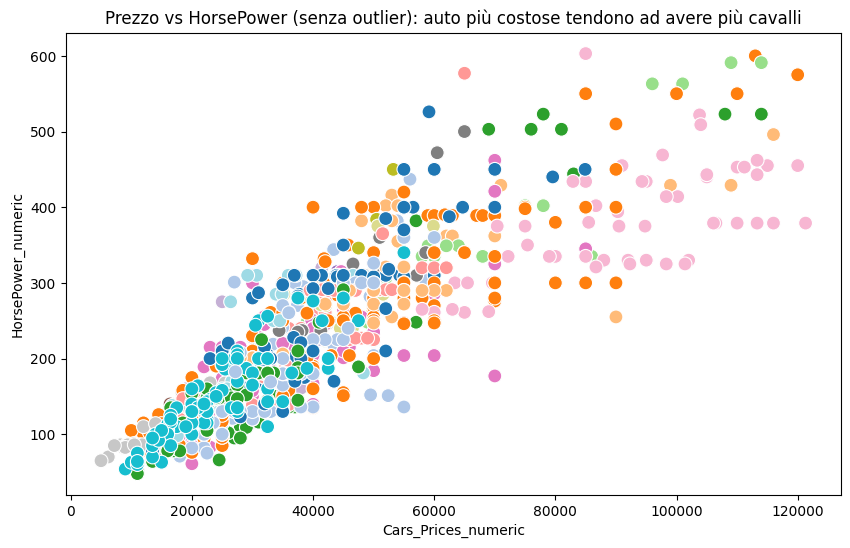

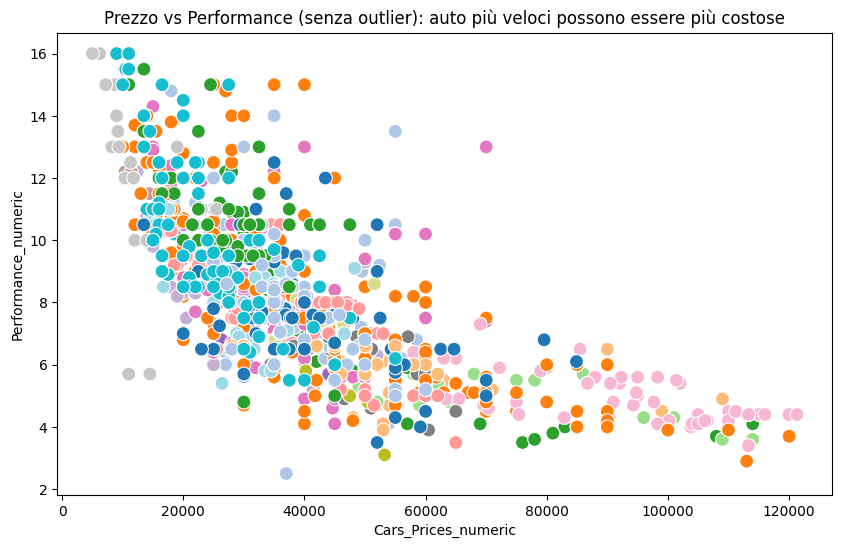

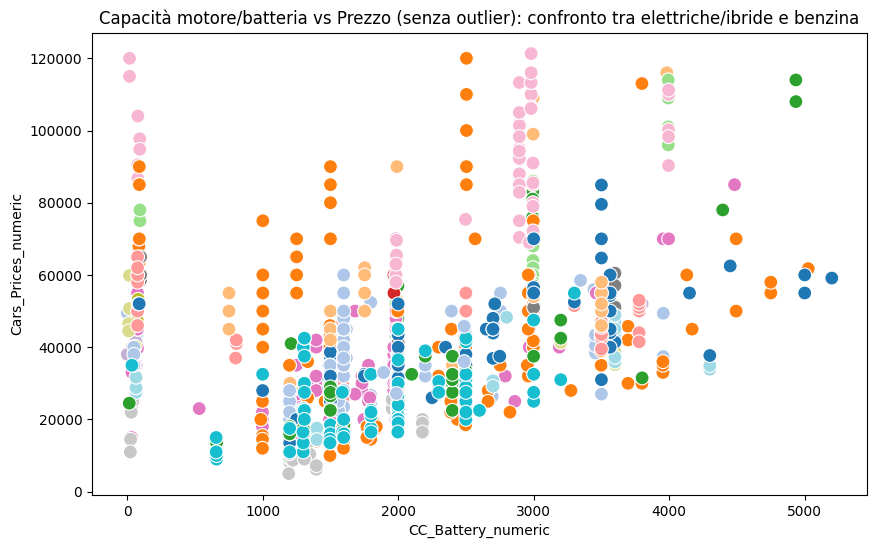

In [328]:
# Lista dei grafici scatter da creare con commenti descrittivi
scatter_plots = [
    ('HorsePower_numeric', 'Total_Speed_numeric', 'HorsePower vs Total Speed (senza outlier): più cavalli => velocità massima maggiore'),
    ('HorsePower_numeric', 'Torque_numeric', 'HorsePower vs Torque (senza outlier): più cavalli => maggiore coppia'),
    ('HorsePower_numeric', 'Performance_numeric', 'HorsePower vs Performance (senza outlier): più cavalli => accelerazione più rapida'),
    ('Total_Speed_numeric', 'Performance_numeric', 'Total Speed vs Performance (senza outlier): velocità massima alta => accelerazione rapida'),
    ('Torque_numeric', 'Performance_numeric', 'Torque vs Performance (senza outlier): maggiore coppia => accelerazione più rapida'),
    ('Cars_Prices_numeric', 'HorsePower_numeric', 'Prezzo vs HorsePower (senza outlier): auto più costose tendono ad avere più cavalli'),
    ('Cars_Prices_numeric', 'Performance_numeric', 'Prezzo vs Performance (senza outlier): auto più veloci possono essere più costose'),
    ('CC_Battery_numeric', 'Cars_Prices_numeric', 'Capacità motore/batteria vs Prezzo (senza outlier): confronto tra elettriche/ibride e benzina')
]

# Creazione dei grafici
for x_col, y_col, comment in scatter_plots:
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        x=x_col, 
        y=y_col, 
        data=df_clean,      # usa il dataframe senza outlier
        hue='Company Names', 
        palette='tab20', 
        s=100
    )
    plt.title(comment)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend([],[], frameon=False)  # nasconde la legenda per chiarezza
    plt.show()

## CREAZIONE CLASSI PREZZO

In [329]:
q1 = df['Cars_Prices_numeric'].quantile(0.33)
q2 = df['Cars_Prices_numeric'].quantile(0.66)

print("Quantile 33%:", q1)
print("Quantile 66%:", q2)

# Creazione funzione per categorizzare
def classify_price(p):
    if pd.isna(p):
        return np.nan
    if p <= q1:
        return "Economy"
    elif p <= q2:
        return "Premium"
    else:
        return "Luxury"

# Applicazione della funzione
df['Price_Category'] = df['Cars_Prices_numeric'].apply(classify_price)

# Controllo risultato
print(df[['Cars_Prices_numeric', 'Price_Category']].head())

Quantile 33%: 32000.0
Quantile 66%: 56779.40000000003
   Cars_Prices_numeric Price_Category
0            1100000.0         Luxury
1             460000.0         Luxury
2              13500.0        Economy
3             161000.0         Luxury
4             253290.0         Luxury


## RAPPOTO POTENZA/PREZZO

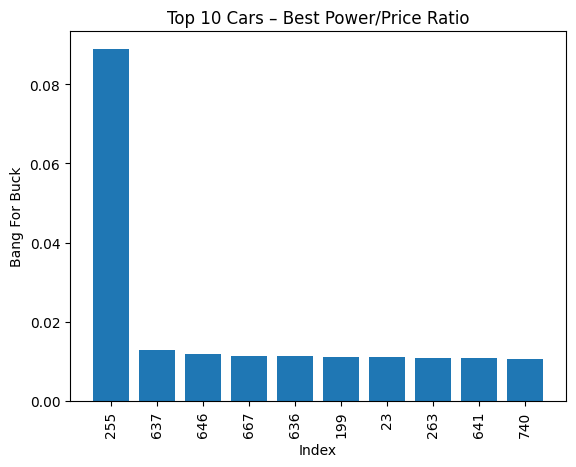

In [330]:
# Creazione Bang_For_Buck
df['Bang_For_Buck'] = np.where(
    df['Cars_Prices_numeric'] > 0,
    df['HorsePower_numeric'] / df['Cars_Prices_numeric'],
    np.nan
)

# Preparazione dati per il grafico
df_bfb = df[['Bang_For_Buck']].dropna()
top10_bfb = df_bfb.sort_values('Bang_For_Buck', ascending=False).head(10)

# Grafico (Bar Chart delle migliori 10 auto)
plt.figure()
plt.bar(top10_bfb.index.astype(str), top10_bfb['Bang_For_Buck'])
plt.xlabel("Index")
plt.ylabel("Bang For Buck")
plt.title("Top 10 Cars – Best Power/Price Ratio")
plt.xticks(rotation=90)
plt.show()

1. Ogni barra rappresenta un’auto (identificata dal suo indice nel dataset).
2. L’altezza della barra mostra quanto è alto il rapporto potenza/prezzo (Bang_For_Buck).
3. Più alta è la barra, più “conveniente” è quell’auto in termini di prestazioni rispetto al prezzo.

## ENGINEERING DELLA CILINDRATA

Fuel Types Clean ['plug-in hybrid' 'petrol' 'diesel' 'hybrid' 'electric' 'hydrogen']

Colonna CC/Battery Capacity:
- auto termiche -> cilindrata (in cc)
- auto elettriche o ibride plug-in -> capacità della batteria (in kWh)

In [331]:
def extract_numeric(s):
    if pd.isna(s):
        return np.nan
    
    s = str(s)
    s = s.replace('–', '-')
    
    # Estraggo tutti i numeri
    nums = re.findall(r'\d+(?:\.\d+)?', s)
    if not nums:
        return np.nan
    
    # Media se intervallo
    nums = [float(x) for x in nums]
    return np.mean(nums)

# Estraggo numero
df["CC_Batt_numeric"] = df["CC/Battery Capacity"].apply(extract_numeric)

# Creo le nuove colonne
def get_engine_cc(row):
    if row["Fuel Types Clean"] in ["petrol", "diesel", "cng/lpg", "hybrid"]:
        return row["CC_Batt_numeric"]
    return np.nan

def get_battery_kwh(row):
    if row["Fuel Types Clean"] in ["electric", "plug-in hybrid"]:
        return row["CC_Batt_numeric"]
    return np.nan

df["Engine_CC"] = df.apply(get_engine_cc, axis=1)
df["Battery_kWh"] = df.apply(get_battery_kwh, axis=1)

print(df[["CC/Battery Capacity", "Fuel Types Clean", "Engine_CC", "Battery_kWh"]])

        CC/Battery Capacity Fuel Types Clean  Engine_CC  Battery_kWh
0                   3990 cc   plug-in hybrid        NaN       3990.0
1                   6749 cc           petrol     6749.0          NaN
2                  1,200 cc           petrol      100.5          NaN
3                  3,982 cc           petrol      492.5          NaN
4                  5,204 cc           petrol      104.5          NaN
...                     ...              ...        ...          ...
1213                2487 cc           hybrid     2487.0          NaN
1214      2393 cc + Battery           hybrid     2393.0          NaN
1215  1987 cc / Hybrid batt           hybrid     1987.0          NaN
1216  1798 / 1987 cc + batt           hybrid     1892.5          NaN
1217         2487 cc + batt   plug-in hybrid        NaN       2487.0

[1218 rows x 4 columns]


## SEGMENTAZIONE PER PRESTAZIONI

   Performance_numeric  Supercar
0                  2.5      True
1                  5.3     False
2                 10.5     False
3                  3.2      True
4                  3.6     False


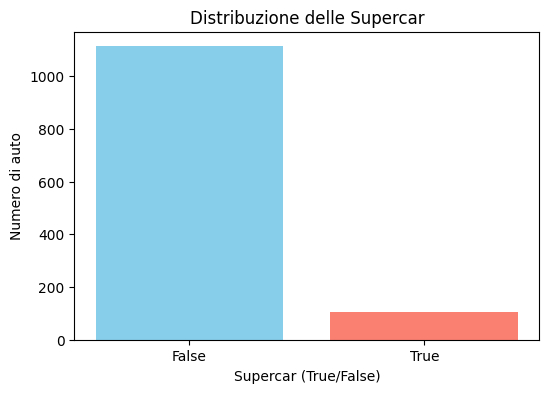

In [332]:
# Creazione feature binaria Supercar: True se accelerazione < 3.5 s
df['Supercar'] = df['Performance_numeric'] < 3.5

# Controllo dei valori
print(df[['Performance_numeric', 'Supercar']].head())

# Grafico della distribuzione Supercar
counts = df['Supercar'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values, color=['skyblue','salmon'])
plt.xlabel("Supercar (True/False)")
plt.ylabel("Numero di auto")
plt.title("Distribuzione delle Supercar")
plt.show()

## NORMALIZZAZIONE 0-1 PER 'TORQUE' E 'HP'

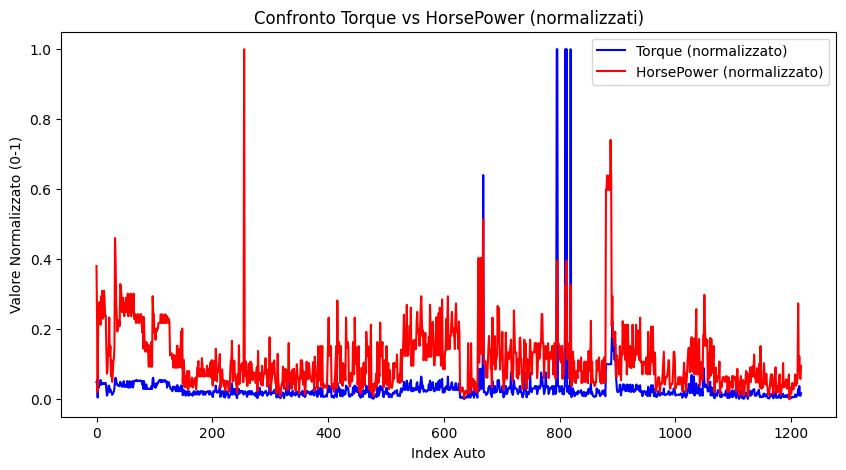

In [333]:
# Normalizzazione 0-1
df['Torque_norm'] = (df['Torque_numeric'] - df['Torque_numeric'].min()) / (df['Torque_numeric'].max() - df['Torque_numeric'].min())
df['HorsePower_norm'] = (df['HorsePower_numeric'] - df['HorsePower_numeric'].min()) / (df['HorsePower_numeric'].max() - df['HorsePower_numeric'].min())

# Grafico comparativo
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Torque_norm'], label='Torque (normalizzato)', color='blue')
plt.plot(df.index, df['HorsePower_norm'], label='HorsePower (normalizzato)', color='red')
plt.xlabel("Index Auto")
plt.ylabel("Valore Normalizzato (0-1)")
plt.title("Confronto Torque vs HorsePower (normalizzati)")
plt.legend()
plt.show()

## ANALISI PER BRAND

In [334]:
prezzi_medi = df.groupby("Company Names")["Cars_Prices_numeric"].mean().sort_values(ascending=False)
print("Prezzo medio per brand:")
print(prezzi_medi)

varianza_prezzi = df.groupby("Company Names")["Cars_Prices_numeric"].var().dropna().sort_values(ascending=False)
print("Varianza prezzo per brand:")
print(varianza_prezzi)

brand_massima_varianza = varianza_prezzi.idxmax()
valore_massima_varianza = varianza_prezzi.max()

print(f"\nIl brand con la varianza di prezzo più alta è: {brand_massima_varianza} ({valore_massima_varianza:.2f})")

Prezzo medio per brand:
Company Names
BUGATTI              5.870000e+06
ASTON MARTIN         7.529491e+05
LAMBORGHINI          6.500833e+05
FERRARI              5.122222e+05
ROLLS ROYCE          3.904000e+05
BENTLEY              3.110000e+05
PORSCHE              1.383896e+05
VOLVO                9.708333e+04
MAZDA                9.382558e+04
TESLA                8.703200e+04
MERCEDES             8.419048e+04
AUDI                 8.287095e+04
JAGUAR LAND ROVER    7.212500e+04
BMW                  6.731707e+04
GMC                  6.329347e+04
ACURA                6.325926e+04
CADILLAC             6.217850e+04
NISSAN               5.919459e+04
FORD                 5.345769e+04
JEEP                 5.143921e+04
CHEVROLET            4.496293e+04
TOYOTA               4.241805e+04
VOLKSWAGEN           3.630124e+04
KIA                  3.601408e+04
PEUGEOT              3.541667e+04
HYUNDAI              3.149561e+04
HONDA                2.936429e+04
MITSUBISHI           2.885000e+04
MAHINDRA  

### Prezzo medio per brand

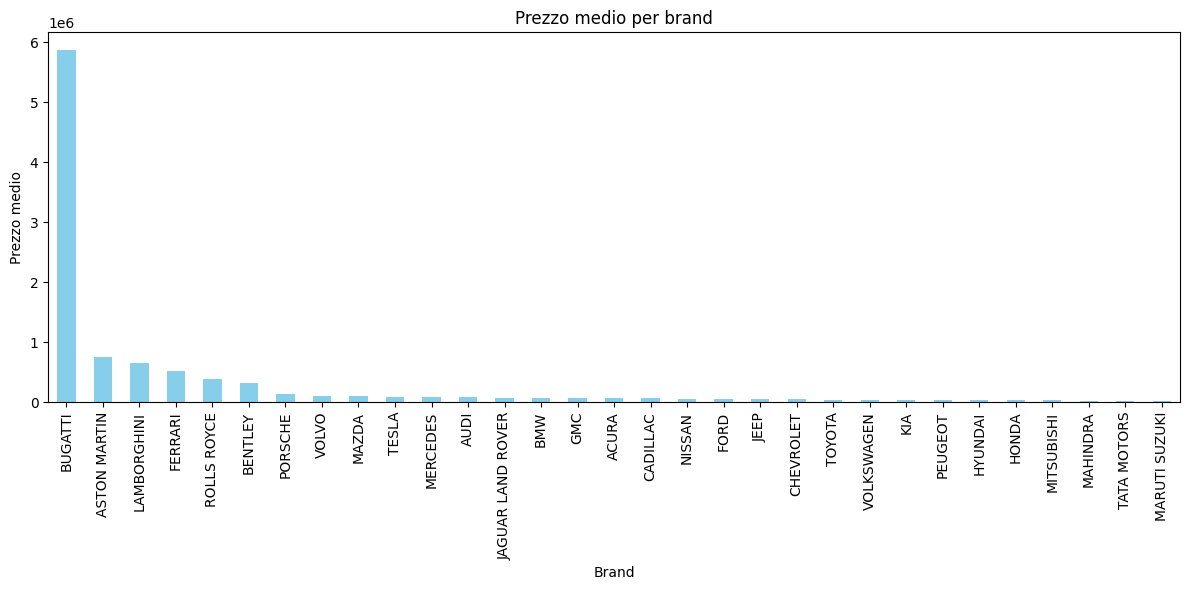

In [335]:
plt.figure(figsize=(12,6))
prezzi_medi.plot(kind="bar", color="skyblue")
plt.title("Prezzo medio per brand")
plt.xlabel("Brand")
plt.ylabel("Prezzo medio")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Varianza di prezzo per brand

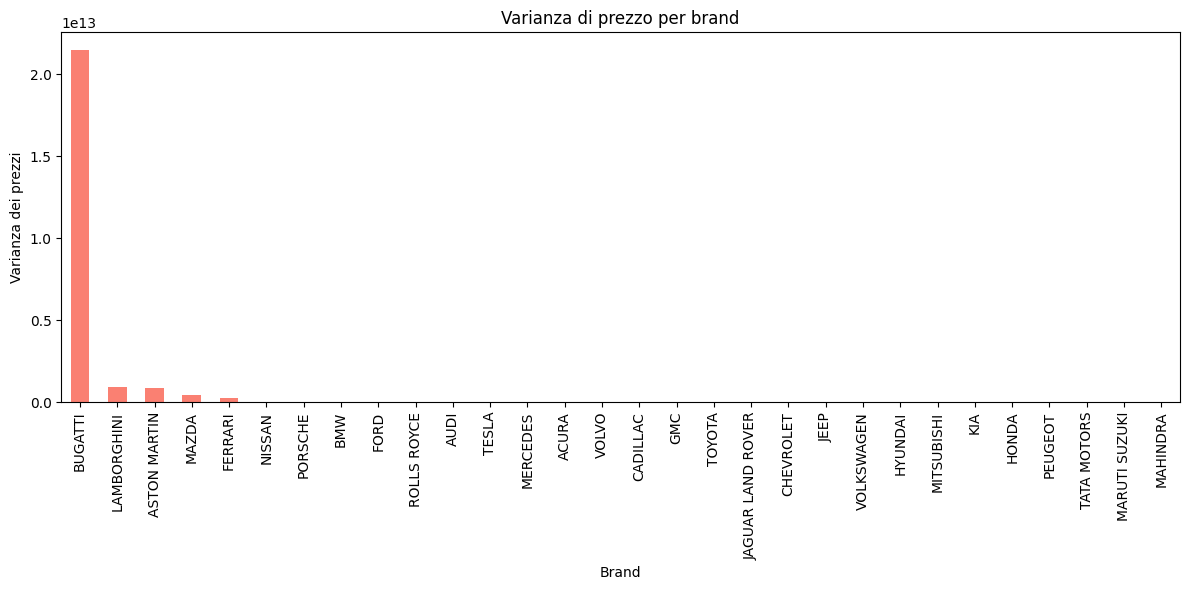

In [336]:
plt.figure(figsize=(12,6))
varianza_prezzi.plot(kind="bar", color="salmon")
plt.title("Varianza di prezzo per brand")
plt.xlabel("Brand")
plt.ylabel("Varianza dei prezzi")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## EFFICIENZA: ELETTRICA VS TERMICA

Performance media 0-100 km/h per tipo di carburante:
Fuel Types
Electric    5.885417
Petrol      7.275890
Name: Performance_numeric, dtype: float64

E' più veloce: Electric (0-100 km/h più veloce)


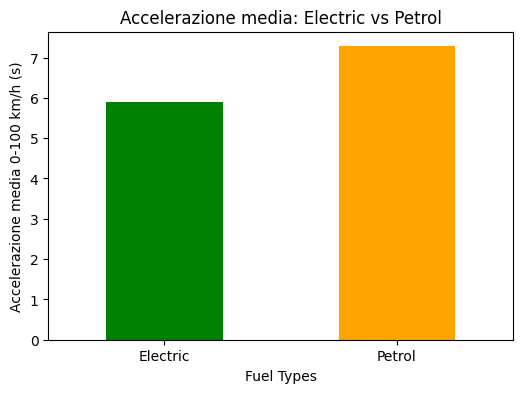

<Figure size 600x400 with 0 Axes>

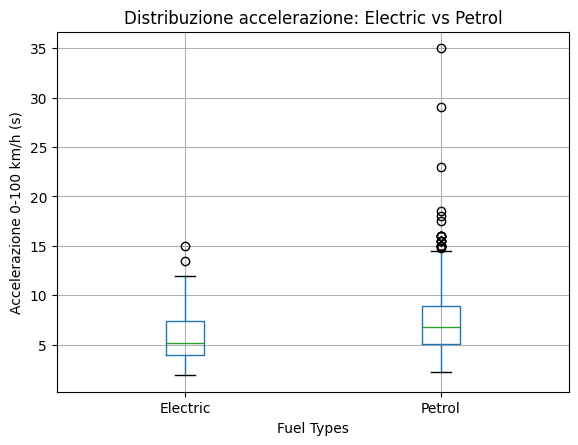

In [337]:
# Filtro solo i tipi di carburante Electric e Petrol
df_fuel = df[df['Fuel Types'].isin(['Electric', 'Petrol'])]

# Calcolo la media dell'accelerazione per tipo di carburante
mean_perf = df_fuel.groupby('Fuel Types')['Performance_numeric'].mean()
print("Performance media 0-100 km/h per tipo di carburante:")
print(mean_perf)

# Determino chi è più veloce
winner = mean_perf.idxmin()
print(f"\nE' più veloce: {winner} (0-100 km/h più veloce)")

#Bar chart con media accelerazione
mean_perf = df_fuel.groupby('Fuel Types')['Performance_numeric'].mean()

plt.figure(figsize=(6,4))
mean_perf.plot(kind='bar', color=['green','orange'])
plt.ylabel("Accelerazione media 0-100 km/h (s)")
plt.title("Accelerazione media: Electric vs Petrol")
plt.xticks(rotation=0)
plt.show()

# Boxplot della distribuzione accelerazione
plt.figure(figsize=(6,4))
df_fuel.boxplot(column='Performance_numeric', by='Fuel Types')
plt.ylabel("Accelerazione 0-100 km/h (s)")
plt.title("Distribuzione accelerazione: Electric vs Petrol")
plt.suptitle("") 
plt.show()

## DISTRIBUZIONE

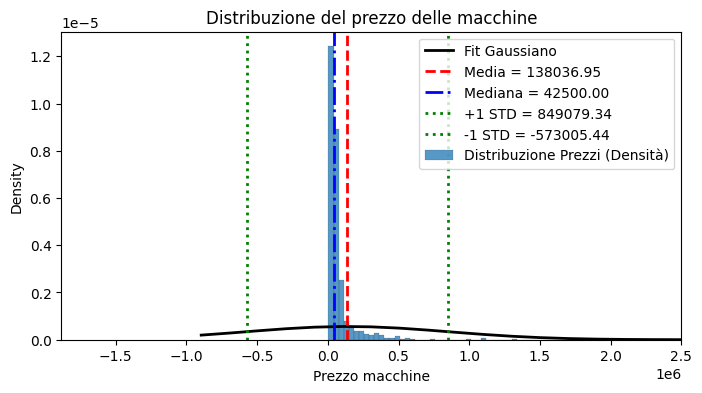

In [338]:
# Istogramma dei prezzi delle auto
plt.figure(figsize=(8,4))
sns.histplot(df["Cars_Prices_numeric"].dropna(), bins=500, kde=False, stat='density', label='Distribuzione Prezzi (Densità)')

mean = df["Cars_Prices_numeric"].mean()
median = df["Cars_Prices_numeric"].median()
std = df["Cars_Prices_numeric"].std()

# Dati per la curva Gaussiana (PDF)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100) # Genero 100 punti uniformemente spaziati nel range
p = norm.pdf(x, mean, std) # Calcolo la Funzione di Densità di Probabilità per ogni punto x
plt.plot(x, p, 'k', linewidth=2, label="Fit Gaussiano")

# Linee statistiche
plt.axvline(mean, color="red", linestyle="--", linewidth=2, label=f"Media = {mean:.2f}")
plt.axvline(median, color="blue", linestyle="-.", linewidth=2, label=f"Mediana = {median:.2f}")
plt.axvline(mean + std, color="green", linestyle=":", linewidth=2, label=f"+1 STD = {mean+std:.2f}")
plt.axvline(mean - std, color="green", linestyle=":", linewidth=2, label=f"-1 STD = {mean-std:.2f}")

plt.xlim(right=0.25e7)

plt.xlabel("Prezzo macchine")
plt.title("Distribuzione del prezzo delle macchine")
plt.legend()
plt.show()

La distribuzione è fortemente non normale (non gaussiana) e asimmetrica verso sinistra -> molte auto poco costose e poche auto molto molto costose

## L'AUTO "MIGLIORE"

In [339]:
cols_for_score = ["Cars_Prices_numeric","Total_Speed_numeric","Performance_numeric"] # Seleziono le tre colonne
score_df = df_clean.copy() # Copio il DF

# Normalizzazione dei dati tra 0 e 1
scaler2 = MinMaxScaler()
score_scaled = scaler2.fit_transform(score_df[cols_for_score])

# price_norm, speed_norm, accel_norm -> [:,x] tutte le righe della colonna 'x'
price_norm = score_scaled[:,0]
speed_norm = score_scaled[:,1]
accel_norm = score_scaled[:,2]

# Assegno i pesi per ogni caratteristica -> maggiore è meglio
w_price, w_speed, w_accel = 0.5, 0.25, 0.25 # Il prezzo è la cosa più importanyte -> vale un 50% del punteggio
score_df["Balanced_Score"] = ( (1 - price_norm) * w_price + speed_norm * w_speed + (1 - accel_norm) * w_accel ) # Il prezzo e il tempo per accelerare se sono alti sono cose negative

# Ordino e mostro top
print("\nTop auto per Balanced Score (maggiore è meglio):")
display(score_df.sort_values("Balanced_Score", ascending=False)[["Company Names","Cars Names","Cars_Prices_numeric","Total_Speed_numeric","Performance_numeric","Balanced_Score"]].head())



Top auto per Balanced Score (maggiore è meglio):


,Company Names,Cars Names,Cars_Prices_numeric,Total_Speed_numeric,Performance_numeric,Balanced_Score
24,NISSAN,Z PROTO,40000.0,290.0,4.1,0.782397
23,NISSAN,370Z,30000.0,250.0,4.7,0.764279
151,BMW,M135i XDRIVE,30000.0,250.0,4.8,0.762427
706,CHEVROLET,Camaro,26400.0,240.0,5.4,0.754293
232,TOYOTA,GR COROLLA,36995.0,230.0,2.5,0.749946


## CREAZIONE NUOVE FEATURE

In [340]:
# Torque per HorsePower -> quanta coppia disponibile per cavallo
df['Torque_per_HP'] = df['Torque_numeric'] / df['HorsePower_numeric']

# Power per CC/Battery -> quanta potenza per unità di cilindrata o capacità batteria
df['Power_per_CC'] = np.where(df['CC_Battery_numeric'] > 0, df['HorsePower_numeric'] / df['CC_Battery_numeric'], np.nan)

print("Prime righe delle nuove feature:")
print(df[['HorsePower_numeric','Torque_numeric','CC_Battery_numeric','Torque_per_HP','Power_per_CC']].head())

Prime righe delle nuove feature:
   HorsePower_numeric  Torque_numeric  CC_Battery_numeric  Torque_per_HP  \
0               963.0           800.0              3990.0       0.830737   
1               563.0           900.0              6749.0       1.598579   
2                77.5           120.0              1200.0       1.548387   
3               630.0           900.0              3982.0       1.428571   
4               602.0           560.0              5204.0       0.930233   

   Power_per_CC  
0      0.241353  
1      0.083420  
2      0.064583  
3      0.158212  
4      0.115680  


### Matrice di correlazione


Matrice di correlazione:
                     HorsePower_numeric  Torque_numeric  CC_Battery_numeric  \
HorsePower_numeric             1.000000        0.400041            0.548480   
Torque_numeric                 0.400041        1.000000            0.107256   
CC_Battery_numeric             0.548480        0.107256            1.000000   
Performance_numeric           -0.640067       -0.207272           -0.228039   
Cars_Prices_numeric            0.507274        0.095808            0.274898   
Torque_per_HP                  0.060538        0.895840           -0.030919   
Power_per_CC                   0.052272        0.064327           -0.187266   

                     Performance_numeric  Cars_Prices_numeric  Torque_per_HP  \
HorsePower_numeric             -0.640067             0.507274       0.060538   
Torque_numeric                 -0.207272             0.095808       0.895840   
CC_Battery_numeric             -0.228039             0.274898      -0.030919   
Performance_numeric  

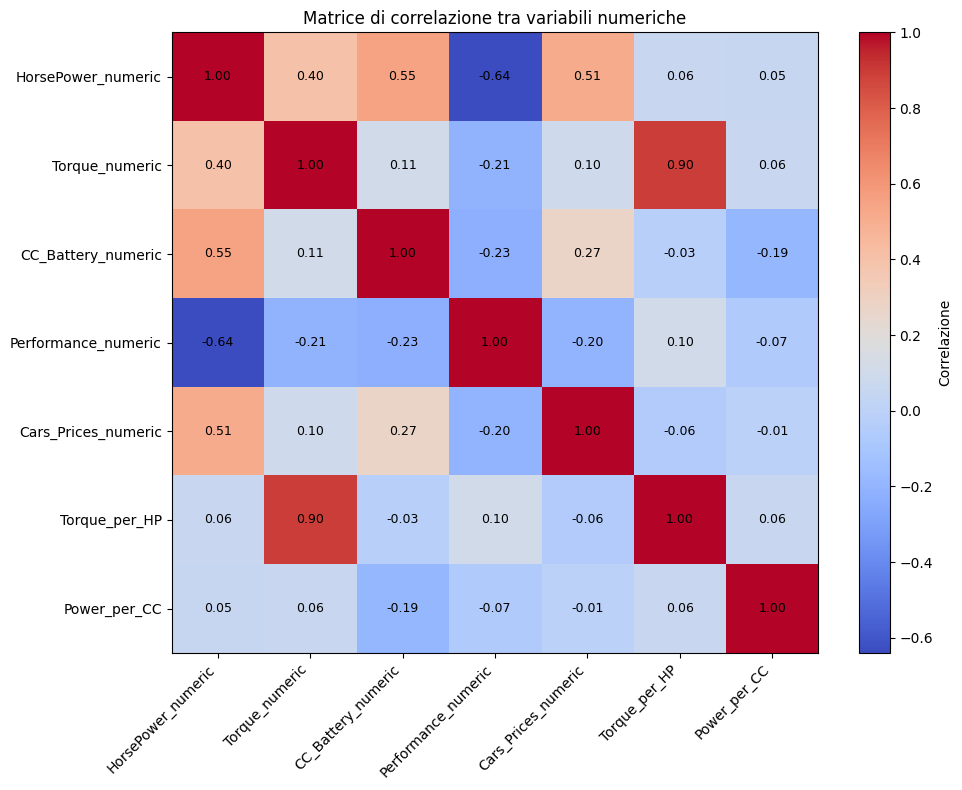

Matrice di correlazione:
                     HorsePower_numeric  Torque_numeric  CC_Battery_numeric  \
HorsePower_numeric             1.000000        0.400041            0.548480   
Torque_numeric                 0.400041        1.000000            0.107256   
CC_Battery_numeric             0.548480        0.107256            1.000000   
Performance_numeric           -0.640067       -0.207272           -0.228039   
Cars_Prices_numeric            0.507274        0.095808            0.274898   
Torque_per_HP                  0.060538        0.895840           -0.030919   
Power_per_CC                   0.052272        0.064327           -0.187266   

                     Performance_numeric  Cars_Prices_numeric  Torque_per_HP  \
HorsePower_numeric             -0.640067             0.507274       0.060538   
Torque_numeric                 -0.207272             0.095808       0.895840   
CC_Battery_numeric             -0.228039             0.274898      -0.030919   
Performance_numeric   

In [341]:
cols_to_corr = ['HorsePower_numeric','Torque_numeric','CC_Battery_numeric',
                'Performance_numeric','Cars_Prices_numeric','Torque_per_HP','Power_per_CC']

corr_matrix = df[cols_to_corr].corr()
print("\nMatrice di correlazione:")
print(corr_matrix)

# Grafico della matrice di correlazione
plt.figure(figsize=(10,8))
im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Correlazione')

# Etichette
plt.xticks(range(len(cols_to_corr)), cols_to_corr, rotation=45, ha='right')
plt.yticks(range(len(cols_to_corr)), cols_to_corr)

# Annotazioni dei valori
for i in range(len(cols_to_corr)):
    for j in range(len(cols_to_corr)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=9)

plt.title("Matrice di correlazione tra variabili numeriche")
plt.tight_layout()
plt.show()

# Stampa matrice per riferimento numerico
print("Matrice di correlazione:")
print(corr_matrix)

### Torque_per_HP VS Accelerazione

Valori più alti di Torque_per_HP indicano motori con più coppia relativa per cavallo.

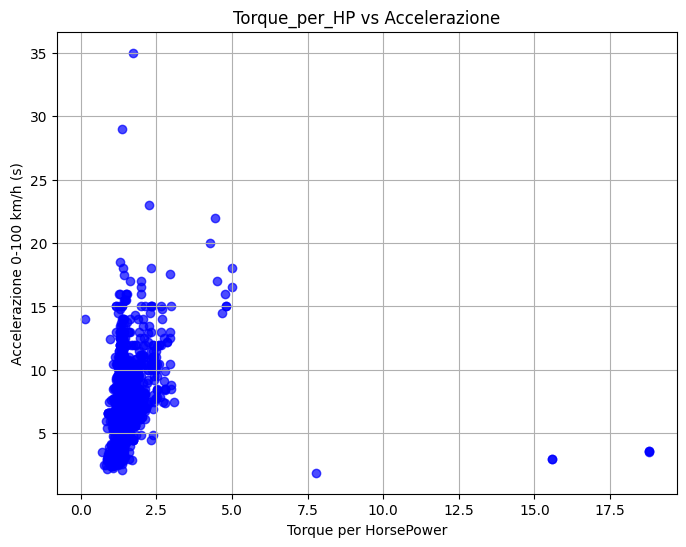

In [342]:
plt.figure(figsize=(8,6))
plt.scatter(df['Torque_per_HP'], df['Performance_numeric'], alpha=0.7, color='blue')
plt.xlabel("Torque per HorsePower")
plt.ylabel("Accelerazione 0-100 km/h (s)")
plt.title("Torque_per_HP vs Accelerazione")
plt.grid(True)
plt.show()

## Power_per_CC VS Accelerazione
Valori più alti di Power_per_CC indicano tanta potenza per unità di cilindrata o batteria.

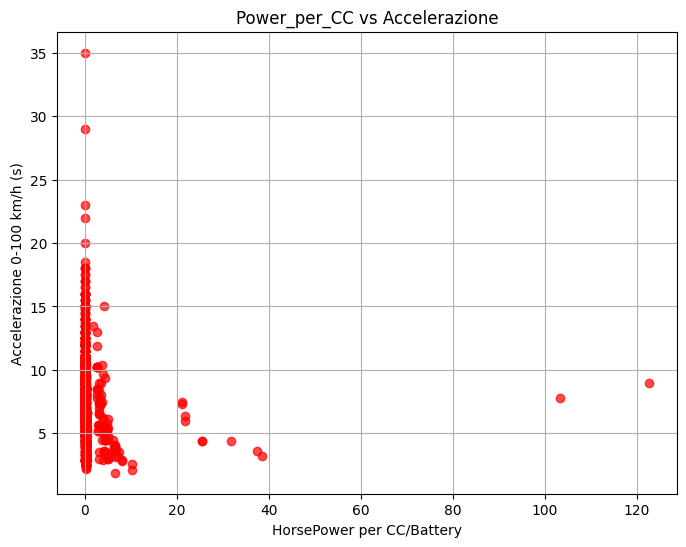

In [343]:
plt.figure(figsize=(8,6))
plt.scatter(df['Power_per_CC'], df['Performance_numeric'], alpha=0.7, color='red')
plt.xlabel("HorsePower per CC/Battery")
plt.ylabel("Accelerazione 0-100 km/h (s)")
plt.title("Power_per_CC vs Accelerazione")
plt.grid(True)
plt.show()